# Lecture 03: Regression

**Slides:** `03_Regression.pdf`

## What you will learn
- Linear regression with scikit-learn
- Model evaluation and residual analysis
- Regularization intuition (Ridge-style)

## Notes
Uses a real-world style dataset and emphasizes interpretation.

## How to use this notebook
1. Run the **Setup** cell below (it will detect the repository root and set paths).
2. Run cells top-to-bottom. If a cell takes too long, skim it and continue — the goal is to learn the workflow, not to optimize runtime.

In [1]:
# --- Setup (run this first) ---
from __future__ import annotations

import os
import sys
from pathlib import Path
from typing import Optional

def _find_repo_root(start: Optional[Path] = None) -> Path:
    """Find repo root by walking upwards and looking for common markers."""
    start = (start or Path.cwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / "pyproject.toml").exists() and (p / "src").exists():
            return p
        if (p / "slides").exists() and (p / "notebooks").exists():
            return p
    return start

PROJECT_ROOT = _find_repo_root()
os.chdir(PROJECT_ROOT)

# Make `import aml_course` work without installing the package.
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# Common paths used in the course.
DATA_DIR = PROJECT_ROOT / "data"
FIGURES_DIR = PROJECT_ROOT / "pictures"
MODELS_DIR = PROJECT_ROOT / "models"

DATA_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"📁 Project root: {PROJECT_ROOT}")
print(f"📦 Data dir:     {DATA_DIR}")
print(f"🖼️  Figures dir:  {FIGURES_DIR}")
print(f"🤖 Models dir:   {MODELS_DIR}")


📁 Project root: /home/leiyo/GitHub/Applied-Machine-Learning-Course
📦 Data dir:     /home/leiyo/GitHub/Applied-Machine-Learning-Course/data
🖼️  Figures dir:  /home/leiyo/GitHub/Applied-Machine-Learning-Course/pictures
🤖 Models dir:   /home/leiyo/GitHub/Applied-Machine-Learning-Course/models


## Part 1 — Dataset and setup

We load a dataset, perform basic preprocessing, and prepare features/targets for modeling.

In [2]:
import requests
import zipfile
import io
import pandas as pd
# URL for the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases\
/00275/Bike-Sharing-Dataset.zip"
# Send a HTTP request to the URL of the webpage you want to access
response = requests.get(url)

In [4]:
# Create a ZipFile object from the response content
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
# Extract the 'day.csv' or 'hour.csv' file from the ZipFile object
csv_file = zip_file.open('day.csv')
# Read the CSV data
data = pd.read_csv(csv_file)

In [7]:
data.shape

(731, 16)

In [6]:
# Print the first 5 rows of the data table
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [9]:
data['mnth'].value_counts()

mnth
1     62
3     62
7     62
5     62
12    62
10    62
8     62
4     60
9     60
6     60
11    60
2     57
Name: count, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split
# Drop the 'dteday' column
data = data.drop('dteday', axis=1)
# Split the data into predictors and target
X = data.drop(['cnt', 'casual', 'registered'], axis=1)
y = data['cnt']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, \
test_size=0.2, random_state=0)

In [12]:
X_train.shape

(584, 12)

In [13]:
X_test.shape

(147, 12)

## Part 2 — Baseline model: linear regression

We fit a linear regression model and evaluate it using standard regression metrics.

In [11]:
from sklearn.linear_model import LinearRegression
# Create a LinearRegression object
regressor = LinearRegression()
# Train the model
regressor.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


<Axes: >

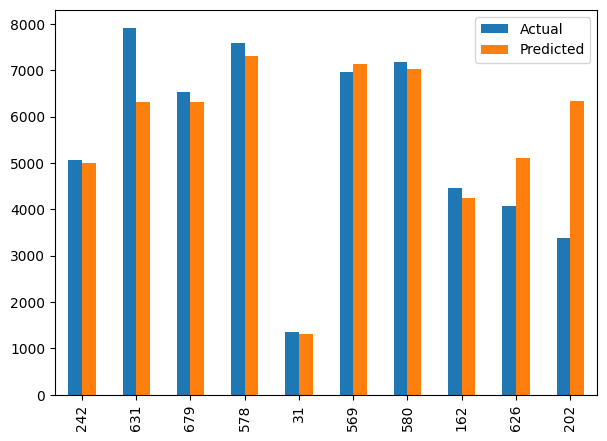

In [14]:
from sklearn import metrics
import matplotlib.pyplot as plt

# Making predictions
y_pred = regressor.predict(X_test)

# Comparing actual result to the predicted result
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.sample(10)

# Visualizing comparison result
df1.plot(kind='bar', figsize=(7,5))

# Save to PDF
# plt.savefig("/pictures/bike_pred_bar.pdf")



In [16]:
regressor.coef_ # \beta_1, \beta_2, ..., \beta_p

array([   -8.65580929,   461.64707734,  5147.04220725,   233.40549827,
        -376.24814037,    73.0771495 ,    81.40535681,  -542.85204984,
        2754.90839226,  2892.06824084, -1229.99054752, -2833.01762887])

In [17]:
regressor.intercept_ # \beta_0

np.float64(1488.569637728016)

In [18]:
X_test

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
196,197,3,0,7,0,6,0,1,0.686667,0.638263,0.585000,0.208342
187,188,3,0,7,0,4,1,1,0.750000,0.686871,0.651250,0.159200
14,15,1,0,1,0,6,0,2,0.233333,0.248112,0.498750,0.157963
31,32,1,0,2,0,2,1,2,0.192174,0.234530,0.829565,0.053213
390,391,1,1,1,0,4,1,2,0.341667,0.356050,0.769583,0.073396
...,...,...,...,...,...,...,...,...,...,...,...,...
566,567,3,1,7,0,5,1,2,0.665833,0.613025,0.844167,0.208967
688,689,4,1,11,0,1,1,2,0.380833,0.375621,0.623333,0.235067
266,267,4,0,9,0,6,0,2,0.606667,0.564412,0.862500,0.078383
504,505,2,1,5,0,6,0,1,0.600000,0.566908,0.456250,0.083975


In [19]:
xx = X_test.reset_index(drop=True).loc[0].values
yy = y_test.reset_index(drop=True).loc[0]

In [20]:
xx

array([197.      ,   3.      ,   0.      ,   7.      ,   0.      ,
         6.      ,   0.      ,   1.      ,   0.686667,   0.638263,
         0.585   ,   0.208342])

In [21]:
yy

np.int64(5923)

In [22]:
regressor.coef_, regressor.intercept_

(array([   -8.65580929,   461.64707734,  5147.04220725,   233.40549827,
         -376.24814037,    73.0771495 ,    81.40535681,  -542.85204984,
         2754.90839226,  2892.06824084, -1229.99054752, -2833.01762887]),
 np.float64(1488.569637728016))

In [25]:
import numpy as np
yy_pred = np.dot(regressor.coef_, xx.T) + regressor.intercept_

In [26]:
yy_pred

np.float64(5125.589578241565)

In [ ]:
# Let us "train" (or "optimize") the model by ourselves manually
import numpy as np

X_train_tmp = X_train.copy()
X_train_tmp['intercept'] = 1

slide_X = X_train_tmp.values
slide_y = y_train.values

# compute inverse of slide_X.T @ slide_X
our_beta = np.linalg.inv(slide_X.T @ slide_X) @ slide_X.T @ slide_y
our_beta

In [ ]:
class MyLinearRegression:
    def __init__(self):
        self.beta = None

    def fit(self, X, y):
        pass

    def predict(self, X):
        pass

my_regressor = MyLinearRegression()
my_regressor.fit(X_train, y_train)
y_pred = my_regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.sample(10)
df1.plot(kind='bar', figsize=(7,5));

In [ ]:
# Make predictions
y_train_pred = my_regressor.predict(X_train)
y_test_pred = my_regressor.predict(X_test)

# Calculate the Mean Squared Error (MSE)
mse_train = 
mse_test = 

In [ ]:
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

In [ ]:
rmse_train / np.mean(y_train)

In [ ]:
rmse_test / np.mean(y_test)

In [ ]:
import numpy as np
from sklearn.metrics import r2_score


# Calculate R-squared
r_squared = r2_score(y_test, y_test_pred)

print(f"R-squared: {r_squared}")

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.scatter(y_test, y_test_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Plot a diagonal line (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')

plt.title(f'R-squared: {r_squared:.2f}')
plt.show()

## Part 3 — Diagnostics: residuals and model fit

Residual analysis is a powerful way to see where a regression model succeeds or fails. We'll visualize residuals and compare actual vs. predicted values.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals plot
plt.figure(figsize=(8, 6))
# plt.subplot(1, 2, 1)
sns.histplot(y_test - y_test_pred, bins=30, kde=True)
plt.title('Distribution of Test Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.savefig('pictures/test_residual.pdf')


In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.scatter(y_test, y_test_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Plot a diagonal line (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')

plt.title(f'R-squared: {r_squared:.2f}')
plt.show()


## Part 4 — Regularization intuition (Ridge-style)

We implement a simplified Ridge-like regression to highlight how adding a penalty term can reduce overfitting and improve generalization.

In [ ]:
class MyRidgeRegression:
    def __init__(self, lambda_=1.0):
        self.lambda_ = lambda_
        self.beta = None

    def fit(self, X, y):
        pass

    def predict(self, X):
        pass
    
my_regressor = MyRidgeRegression()
my_regressor.fit(X_train, y_train)
y_pred = my_regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.sample(10)
df1.plot(kind='bar', figsize=(7,5));


In [ ]:
# Make predictions
y_train_pred = my_regressor.predict(X_train)
y_test_pred = my_regressor.predict(X_test)

# Calculate the Mean Squared Error (MSE)
mse_train = np.mean((y_train - y_train_pred)**2)
mse_test = np.mean((y_test - y_test_pred)**2)

In [ ]:
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

In [ ]:
rmse_train / np.mean(y_train)

In [ ]:
rmse_test / np.mean(y_test)